<br><br><br><br><br>



<center>
<b><font size="+3">CS481-Lecture 11: Text Classification </font></b>
<br>
*[Illinois Institute of Technology](http://iit.edu)*

</center>

<br><br><br><br><br><br><br>


# Text classification:

The process of categorizing text into pre-defined groups/classes

<img src="classification.png" width="600" align="left">

<br><br><br><br><br><br><br><br>
Organize unstructured text to extract value and get insights into:
    - social media messages
    - emails
    - online conversations (chat-bots)
    - websites
    
    
- **Applications** of automatic text classification:
    - Sentiment Analysis: understand the view / attitute / feeling / emotion toward a situation or event. We do text classification to analyze if a given text is talking positively or negatively about a given subject (e.g. pos/neg movie review). 

    - Topic Labeling: identify the theme or topic in the text (e.g. analyze the topics of news articles: entertainment, business, politics).

    - Spam Detection: detect whether an email is spam or not.



- **Approaches**:
    - manual
        - human annotator read and label the text
        - platform: AMT
        - pros: high quality
        - cons: time consuming and expensive  
        
    - automatic        
        - rule-based
            - pre-define a set of linguistic rules
            - instruct the system to use semantically relevant elements of a text to identify relevant categories based on its content
            - E.g., classify news article into sports and politics
                - sports-related keywords: football, basketball, LeBron James
                - politics-related keywords: government, Washington, Obama, Donald Trump, Hillary Clinton, etc.
            - cons: difficult and expensive to maintain

        - **machine learning-based**
            - train a classifier based on pre-labeled training data
            - apply the classifier to make predictions on new data
            - pros: fast, effective, accurate
            - cons: need pre-labeled training data


## Binary sentiment classification for IMDb movie reviews:

- IMDb: Internet Movie Database, is an online database of information related to films, television programs, and so on.
- Task: train a binary classification model to predict whether a movie review is positive or negative.

<img src="IMDb_review.png" width="600">

# Import libraries

In [113]:
import time, os

import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_colwidth', -1) # display the entire contents of each cell

import seaborn as sns # visualization
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load and explore the data
The data is available at this source, and you can learn more about how and why this dataset is created from this paper. <br>
Data source: https://ai.stanford.edu/~amaas/data/sentiment/ <br>
Paper: [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) <br>

In [114]:
# we first download the data, and then use pandas dataframe to load the data from file
df_data = pd.read_csv('IMDB Dataset.csv')
df_data.shape, display(df_data.head())
# we can see there are 50,000 reviews, each review is either positive or negative

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

((50000, 2), None)

In [55]:
# this is an example of negative review
df_data.iloc[10].sentiment, df_data.iloc[10].review

('negative',
 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"')

We then explore more about this data

In [56]:
# check empty cells
df_data.isnull().sum() 

review       0
sentiment    0
dtype: int64

In [57]:
# remove duplicate samples
df_data = df_data.drop_duplicates(keep="first")
df_data.shape
# compare with the original data 50,000, we removed about 500 duplicate samples

(49582, 2)

In [58]:
# check if pos and neg sentiments are balanced
df_data.sentiment.value_counts() 

positive    24884
negative    24698
Name: sentiment, dtype: int64

The dataset is equally distributed, which is great for building the model.

Now, lets check the length of the reviews

In [59]:
df_data['length'] = df_data['review'].apply(len) # number of characters
df_data['length'].describe() # info()
# the describe function shows the mean, std, min, max of length of the reviews

count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: length, dtype: float64

In [60]:
# we have a new column 'length' added to the dataframe
df_data.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


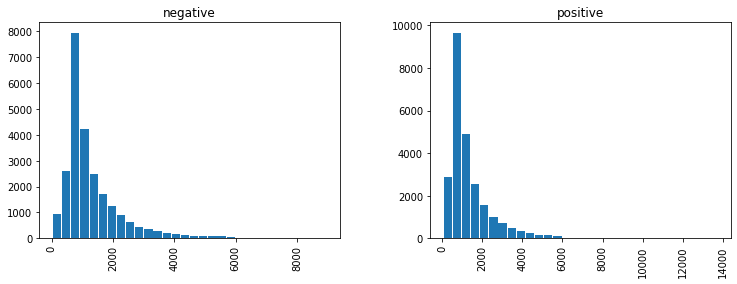

In [61]:
# plot the distribution of the length of positive and negative reviews
# x: length of reviews; y: number of reviews fall into each interval
df_data.hist(column='length', by='sentiment',bins=30, figsize=(12,4),rwidth=0.9)
plt.show()

Looking at the above distribution, we can say that there is no clear difference between postive and negative reviews based on the length of the review.

After the exploration, we now have a basic understanding of the dataset.
Lets go ahead to clean the reviews.

# Text Preprocessing 
There are many approaches for text preprocessing, such as:
- lowercasing
- data cleaning 
    > remove special characters, emails, urls <br>
    > remove stopwords <br>
    > remove punctuations <br>
        
- normalization
    > stemming 
        - chops off the ends of words to transform words into their root forms (e.g., connected->connect)
        - PorterStemmer, SnowballStemmer
    > lemmatization
        - map a word to its root form (dictionary, rule-based) based on the context, POS, intended meaning
        - WordNetLemmatizer
        - transforming texts into a standard forms (abbreviations, misspellings, out-of-vocabulary words; e.g., gooood->good)
    > De-contract
        - expand the contracted words into normal words (I'm -> I am)

The specific steps to apply depends on your task. <br>
For our task of analyzing IMDb movie reviews data, we mainly focus on **data cleaning**, such as removing:

> HTML tags <br>
> special / non-alphabetic characters <br>
> url <br>
> emails <br>

In [62]:
# Here is an example of the review, we can see that ...
df_data.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [63]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['review']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

df_data['cleaned_review'] = clean_text(df_data)
# df_data['cleaned_review'] = df_data.apply(clean_text)
# df_data = df_data.drop(columns=['review'])

df_data.head()
# After the cleaning process, we get the cleaned_reviews

100%|██████████| 49582/49582 [00:25<00:00, 1946.93it/s]


,review,sentiment,length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,998,A wonderful little production The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,926,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,748,Basically there is a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,Petter Mattei is Love in the Time of Money i...


In [64]:
# example of a review before and after cleaning, we can see that the punctuations and html tags are removed.

print(df_data['review'][9],'\n')

print(df_data['cleaned_review'][9])

If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!! 

If you like original gut wrenching laughter you will like this movie  If you are young or old then you will love this movie  hell even my mom liked it Great Camp   


Before moving forward, we convert the sentiments to binary labels, the corresponding label for postive sentiment is 1 and 0 for negative.

In [65]:
df_data['label'] = df_data['sentiment'].map({'positive':1,'negative':0})
df_data.head()[['cleaned_review','sentiment','label']]

,cleaned_review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there is a family where a little boy...,negative,0
4,Petter Mattei is Love in the Time of Money i...,positive,1


# **Pipeline** for training a text classifier
<img src="training.png" width="800" align="center">

## Tools and packages for ML:
- **scikit-learn**: https://scikit-learn.org/stable/
- a free software machine learning library for Python 
- algorithms for:
    - feature engineering
    - classification
    - regression 
    - clustering
    - evaluation metric (e.g., precision, recall)

## Feature Engineering

Feature engineering for text is the process of transforming a collection of texts into numerical feature vectors (vectorization) that the computers can understand.
- Bag-of-words representation: documents are described by word occurrences while completely ignoring the relative position information of the words in the document
- Vectorization: tokenization, counting and normalization


**Feature engineering techniques**:
- Units / levels
    > words <br>
    > ngram / phrases <br>
    > sentences <br>
    > POS tag <br>
- doc:
    > https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

- CountVectorizer 
    > represent document as a vector of word counts
- TfidfVectorizer 
    > term-frequency * inverse document-frequency
    > reduce very frequent terms (e.g., 'a', 'the', 'is')
- Embedding 
    > represent words into high-dimensional vectors
    > word2vec, BERT, GPT, ...

### CountVectorizer
- Convert a collection of text documents to a matrix of token counts
- doc: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
corpus = [
         'This is the first document.',
         'This document is the second document.',
         'And this is the third one.',
         'Is this the first document?',
        ]

In [27]:
ct_vectorizer = CountVectorizer()
X = ct_vectorizer.fit_transform(corpus) # Learn the vocabulary dictionary and return document-term matrix
print(X.toarray())
# columns represent features
# each row corresponds to a document

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [28]:
ct_vectorizer = CountVectorizer(max_df = 0.8) # 4*0.8
X = ct_vectorizer.fit_transform(corpus) # Learn the vocabulary dictionary and return document-term matrix
print(X.toarray())

[[0 1 1 0 0 0]
 [0 2 0 0 1 0]
 [1 0 0 1 0 1]
 [0 1 1 0 0 0]]


In [29]:
print(type(X))
# print(X)
X

<class 'scipy.sparse.csr.csr_matrix'>


<4x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [30]:
print(ct_vectorizer.get_feature_names()) # Array mapping from feature integer indices to feature name

['and', 'document', 'first', 'one', 'second', 'third']


In [31]:
ct_vectorizer.vocabulary_ # A mapping from terms to feature indices

{'first': 2, 'document': 1, 'second': 4, 'and': 0, 'third': 5, 'one': 3}

- ngrams as features

In [32]:
ct_vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X2 = ct_vectorizer2.fit_transform(corpus)

print(X2.toarray())

[[0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 0 2 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0]
 [0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1]]


In [33]:
print(ct_vectorizer2.get_feature_names())

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']


- Other important parameters:
    > min_df: ignore terms that have a document frequency lower than the given threshold <br>
    > max_df: ignore terms that have a document frequency lower than the given threshold(e.g., corpus-specific stop words) <br>
    > lowercase <br>
    > max_features <br>
    > vocabulary <br>
    > binary <br>

### TfidfVectorizer
- doc: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- **tf-idf(t,d)** = tf(t,d)*idf(t)

    - **tf(t,d)**: term-frequency, the number of times a term t occurs in a the document d

    - **idf(t)**: inverse document frequency
        - (norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

<img src="idf.png" width="300" align="center">


- Normalize the resulting tf-idf vectors by the **Euclidean norm**:
    - Normalize each output row with unit norm
        - https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
        - **l2 norm**: sum of squares of vector elements is 1
        - l1 norm: sum of absolute values of vector elements is 1
        
<img src="euclidean_norm.png" width="500" align="center">

- tf(t,d), term frequency

In [34]:
ct_vectorizer = CountVectorizer()
X = ct_vectorizer.fit_transform(corpus)
print(X.toarray())

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


- idf(t): inverse document frequency

In [37]:
# calculate df(t)
vectorizer = CountVectorizer(binary=True) # binary representation
X_bi = vectorizer.fit_transform(corpus) 
df_t_list = X_bi.sum(axis=0).tolist()[0] # document frequency for each feature
df_t_list

[1, 3, 2, 4, 1, 1, 4, 1, 4]

In [40]:
# calculate inverse document frequenct

idf_list = []
n = 4
for df_t in df_t_list:
    idf_list.append(np.log((1+n)/(1+df_t))+1)

print(idf_list)

[1.916290731874155, 1.2231435513142097, 1.5108256237659907, 1.0, 1.916290731874155, 1.916290731874155, 1.0, 1.916290731874155, 1.0]


In [45]:
# calculate tf*idf
tf_list = X.toarray()[0]
tf_idf_list = []
for tf,idf in zip(tf_list, idf_list):
    tf_idf_list.append(tf*idf)

print(tf_idf_list)

[0.0, 1.2231435513142097, 1.5108256237659907, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]


In [48]:
# normalize each output row (l2 norm)
square_sum = 0
for tf_idf in tf_idf_list:
    square_sum += tf_idf**2
    
tf_idf_norm = []
for tf_idf in tf_idf_list:
    tf_idf_norm.append(tf_idf/np.sqrt(square_sum))

print(tf_idf_norm)

[0.0, 0.46979138557992045, 0.5802858236844359, 0.38408524091481483, 0.0, 0.0, 0.38408524091481483, 0.0, 0.38408524091481483]


- Use TfidfVectorizer to integrate all the process into one line of code

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
X = vectorizer.fit_transform(corpus)
print(X.shape)
print(X.toarray())

(4, 9)
[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


In [51]:
print(vectorizer.get_feature_names())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


### Feature engineering for this task (sentiment classification for IMDb movie reviews) 
- use the **scikit-learn** implementation of [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to convert the movie reviews into a 2-d matrix.

In [66]:
# print(stopwords.words('english'))
#Exluding NO, NOR, NOT from the stop words as they play keyrole
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


# CountVectorizer: lowercase the text, use a self-defined stopwords list to remove stopwords
# Will talk about how to tune these parameters later.
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)
y = df_data.label.values

print("X.shape : ",X.shape)
print("y.shape : ",y.shape)

# y is the array of sentiment labels

# X is the 2-d matrix of vector representation of the cleaned reviews
# each row corresponds to each document and each column corresponds to each feature
# accoring to the shape of X, we can tell the number of samples, the number of features (size of vocabulary)

X.shape :  (49582, 47192)
y.shape :  (49582,)


# Train test split
- Shuffle the data 
- Split the data into training and testing by 80:20 ratio
- Assign a random state for reproducible output

In [95]:
df_data.shape

(49582, 5)

In [93]:
# index is not continuous because some rows are deleted during data pre-processing
df_data.tail(10)

,review,sentiment,length,cleaned_review,label
49989,I got this one a few weeks ago and love it! It...,positive,967,I got this one a few weeks ago and love it It...,1
49990,"Lame, lame, lame!!! A 90-minute cringe-fest th...",negative,799,Lame lame lame A minute cringe fest th...,0
49992,John Garfield plays a Marine who is blinded by...,positive,968,John Garfield plays a Marine who is blinded by...,1
49993,Robert Colomb has two full-time jobs. He's kno...,negative,2717,Robert Colomb has two full time jobs He is kn...,0
49994,This is your typical junk comedy.<br /><br />T...,negative,759,This is your typical junk comedy There are alm...,0
49995,I thought this movie did a down right good job...,positive,1008,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,Bad plot bad dialogue bad acting idiotic di...,0
49997,I am a Catholic taught in parochial elementary...,negative,1280,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,negative,1234,I am going to have to disagree with the previo...,0
49999,No one expects the Star Trek movies to be high...,negative,678,No one expects the Star Trek movies to be high...,0


In [108]:
# reset the index to make it continuous 
# make the index for X (vector representation) consistent with the index for the documents
# make the vector representation of the data align with the raw text
df_data_reidx = df_data.reset_index(drop=True)
df_data_reidx.tail()

,review,sentiment,length,cleaned_review,label
49577,I thought this movie did a down right good job...,positive,1008,I thought this movie did a down right good job...,1
49578,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,642,Bad plot bad dialogue bad acting idiotic di...,0
49579,I am a Catholic taught in parochial elementary...,negative,1280,I am a Catholic taught in parochial elementary...,0
49580,I'm going to have to disagree with the previou...,negative,1234,I am going to have to disagree with the previo...,0
49581,No one expects the Star Trek movies to be high...,negative,678,No one expects the Star Trek movies to be high...,0


In [64]:
from sklearn.model_selection import train_test_split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [97]:
train_idx, test_idx = train_test_split(np.arange(df_data_reidx.shape[0]), test_size=0.2, shuffle=True, random_state=42)
len(train_idx), len(test_idx)
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}".format(len(test_idx)))

Number of training examples:39665
Number of testing examples:9917


In [98]:
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (39665, 47192), y_train : (39665,)
Testing data: X_test : (9917, 47192), y_test : (9917,)


In [130]:
# df_train.head()

In [131]:
# df_test.head()

# Model Training

After we do text preprocessing, feature engineering, and train test split, the next step is model training, we need to decide which model to use. For example, there are:

- Logistic Regression
- Naive Bayes
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machines
- (Deep) Neural Networks
- ... many many more

<img src="training_prediction.png" width="800" align="center">

## Logistic regression
In this task, we will use **Logistic regression**, which is one of the most popular and interpretable machine learning algorithm for binary classification.


**Linear Regression**: linear combination of independent variables,
$$
    t = \sum_{i} {\beta_i*x_i}
$$

**Logistic Regression**: regression with output constrained between 0 and 1 with a **sigmoid logistic function**, as we see here, combine the linear regression with a logistic function, we get the logistic regression function:
  
$$ 
    \hat{y} = \frac{1}{1 + \exp^{(- t)}}  = \frac{1}{1 + \exp^{(-\sum_i\beta_i x_i)}} 
$$

- $x_i$ is value of feature $i$ in an instance (count of a word)<br>
- $\beta_i$ is the real-valued model parameter associated with feature $i$ <br>
  - E.g., high $\beta_i$ means feature $i$ is predictive of positive class ($y=1$) <br>
- $\hat{y}$ is the probability of being positive, $y$ is the actual label <br>
    - If $\hat{y} > .5$, classify as positive, $y = 1$ <br>


<img src="Logistic_curve.png" width="400">

In [109]:
# fit a logistic regression classifier on the training data use default settings
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# make prediction on testing data
y_pred_test = lr_clf.predict(X_test)

In [110]:
y_pred_test

array([0, 1, 0, ..., 0, 0, 0])

### Explain the model prediction
- Check the reviews that the model fails to predict its true sentiment
- Check the top features that are predictive of positive sentiments and negative sentiments

In [119]:
df_test = df_data_reidx.iloc[test_idx]
df_test['pred_label'] = y_pred_test
df_test.head(3)[['review','label','pred_label']]

,review,label,pred_label
29035,"""Soul Plane"" is a horrible attempt at comedy that only should appeal people with thick skulls, bloodshot eyes and furry pawns. <br /><br />The plot is not only incoherent but also non-existent, acting is mostly sub sub-par with a gang of highly moronic and dreadful characters thrown in for bad measure, jokes are often spotted miles ahead and almost never even a bit amusing. This movie lacks any structure and is full of racial stereotypes that must have seemed old even in the fifties, the only thing it really has going for it is some pretty ladies, but really, if you want that you can rent something from the ""Adult"" section. OK?<br /><br />I can hardly see anything here to recommend since you'll probably have a lot a better and productive time chasing rats with a sledgehammer or inventing waterproof teabags or whatever.<br /><br />2/10",0,0
43282,"Guest from the Future tells a fascinating story of time travel, friendship, battle of good and evil -- all with a small budget, child actors, and few special effects. Something for Spielberg and Lucas to learn from. ;) A sixth-grader Kolya ""Nick"" Gerasimov finds a time machine in the basement of a decrepit building and travels 100 years into the future. He discovers a near-perfect, utopian society where robots play guitars and write poetry, everyone is kind to each other and people enjoy everything technology has to offer. Alice is the daughter of a prominent scientist who invented a device called Mielophone that allows to read minds of humans and animals. The device can be put to both good and bad use, depending on whose hands it falls into. When two evil space pirates from Saturn who want to rule the universe attempt to steal Mielophone, it falls into the hands of 20th century school boy Nick. With the pirates hot on his tracks, he travels back to his time, followed by the pirates, and Alice. Chaos, confusion and funny situations follow as the luckless pirates try to blend in with the earthlings. Alice enrolls in the same school Nick goes to and demonstrates superhuman abilities in PE class. The catch is, Alice doesn't know what Nick looks like, while the pirates do. Also, the pirates are able to change their appearance and turn literally into anyone. (Hmm, I wonder if this is where James Cameron got the idea for Terminator...) Who gets to Nick -- and Mielophone -- first? Excellent plot, non-stop adventures, and great soundtrack. I wish Hollywood made kid movies like this one...",1,1
38461,"""National Treasure"" (2004) is a thoroughly misguided hodge-podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy cliché that has ever been written. The film stars Nicholas Cage as Benjamin Franklin Gates (how precious is that, I ask you?); a seemingly normal fellow who, for no other reason than being of a lineage of like-minded misguided fortune hunters, decides to steal a 'national treasure' that has been hidden by the United States founding fathers. After a bit of subtext and background that plays laughably (unintentionally) like Indiana Jones meets The Patriot, the film degenerates into one misguided whimsy after another  attempting to create a 'Stanley Goodspeed' regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane, but disconnected misadventures.<br /><br />The relevancy and logic to having George Washington and his motley crew of patriots burying a king's ransom someplace on native soil, and then, going through the meticulous plan of leaving clues scattered throughout U.S. currency art work, is something that director Jon Turteltaub never quite gets around to explaining. Couldn't Washington found better usage for such wealth during the start up of the country? Hence, we are left with a mystery built on top of an enigma that is already on shaky ground by the time Ben appoints himself the new custodian of this untold wealth. Ben's intentions are noble  if co

In [120]:
df_test[df_test['label'] != df_test['pred_label']].head()[['review','label','pred_label']]

,review,label,pred_label
47410,"His significant charisma and commanding presence are about all that keep this afloat, but Fred Williamson has done far better urban action films including many of his later, vid-released fare. The big studios' Williamson films of the early-to-mid 70's rarely had the punch of their mid-level counterparts, and this is a prime example. Clumsy action, little violence, and the PG rating is nowhere near questionable. Worth a look for Hammer completists in any case.",0,1
30610,"I preface by stating I am a big fan of JJL and NOT one of Patrick. Therefore I watched this to see her performance and of course, it was excellent. I do not feel the director was adequate for the film as several very bad choices were made re: shot angles, blocking, etc. If the director was trying to give it a ""realistic"" feel, they failed and lost some good performances because of it. Nearly always felt that the camera was way too static, too far from intense facial reactions -- and so many times when the action depended on the intimacy of lead characters, the dialog was slow and plodding. This easily could have been resolved by cutaways or changes of camera angle. But the impression I got was that the budget was too small and only one camera was used! I also got the impression that perhaps scenes were shot multiple times and the energy coming from the actors was... used up.",0,1
39877,"A horror movie is being shot and things aren't going well. It's about a masked killer. The director tells off the killer in front of the cast and crew. He goes crazy and kills two people. He's killed himself and the film is never finished. Twelve years later a bunch of film students decide to try and finish it--but there's a curse. People who try and finish it are killed themselves. The students ignore that. Guess what happens next?<br /><br />The plot is old hat but this isn't bad...for what it is (a low budget slasher film). It's well-made with a young and fairly talented young cast. No one is great but no one is terrible either. It also avoids the obligatory (and needless) female nude scenes. It moves quickly, the gore is nice and bloody and the script doesn't insult your intelligence. Also Molly Ringwald is in this having the time of her life playing a bitchy faded actress.<br /><br />No great shakes but not bad at all. I give it a 7.",1,0
42613,"There is only one racist joke in this Daffy Duck short, which is basically, when Daffy rides Black Beauty, it is a black woman. I can understand partly why this joke was included, as at the time few people did not know how rude it was to be racist and it wasn't even illegal to discriminate black people yet.<br /><br />Aside from this point, ""A Coy Decoy"" is basically a fun, interesting short where Daffy meets characters in books and does things in books. I liked this short quite a lot (despite the other reviewers on here). The way Daffy is so in love with the clockwork duck is vaguely disturbing, yet highly amusing at the same time. Porky is a nice edition to the episode, though it was not vital for him to be there. The wolf is an example of how people thought of wolves in those days as well, blood-thirsty, terrible animals, which of course they never really have been (unless they are very hungry). I also liked the style of animation used - and the theme of the episode.<br /><br />For people who are totally into Daffy Duck and for people who do not mind the occasional racist joke in cartoons, enjoy ""A Coy Decoy""!<br /><br />Available on YouTube.",1,0
42860,"I've been a classic horror fan my entire life. Many nights stretched until the early hours of the morning watching the Universal films on ""Horror Incorporated"" and ""Creature Feature Night"". Sadly, I viewed this film in the early evening and yet it still almost put me to sleep.<br /><br />I don't think I've ever seen a ""horror"" picture where everything was so matter of fact. Dr. Edelmann doesn't seem to believe in the supernatural, yet 

- Top-10 words that are predictive of positive class

In [124]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

# words like "refreshing, hooked, superb" are reliable evidence of indicating positive sentiments

Top positive features:


[('refreshing', 1.865),
 ('disappoint', 1.85),
 ('hooked', 1.716),
 ('superb', 1.444),
 ('entertains', 1.409),
 ('squirrel', 1.409),
 ('adr', 1.382),
 ('ringwald', 1.358),
 ('perfect', 1.343),
 ('excellent', 1.336)]

- Top-10 words that are predictive of negative class

In [125]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('waste', -2.173),
 ('worst', -2.146),
 ('uninteresting', -1.95),
 ('disappointment', -1.824),
 ('mildly', -1.733),
 ('forgettable', -1.714),
 ('stinker', -1.627),
 ('awful', -1.577),
 ('dreadful', -1.554),
 ('fails', -1.548)]

# Model Evaluation
- train test split
- k-fold cross-validation 
> train on k-1 folds, test on 1 fold, repeat k times <br>
> each instance appears only once in test set <br>

- Scoring metrics
> assign different scoring metrics to check the model performance from different aspects <br>
> https://scikit-learn.org/stable/modules/model_evaluation.html <br>
> precision, recall, f1 <br>
> accuracy <br>
> roc_auc <br>

In [126]:
print(classification_report(y_test, y_pred_test))
# micro average (averaging the total true positives, false negatives and false positives globally, true pos of one class / (all true pos + all false pos))
# macro average (averaging the unweighted mean per label)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.88      4978

   micro avg       0.88      0.88      0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



According to the evaluation scores we can say that the model is working pretty decent.

In [129]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_clf, X, y, cv=5, scoring='precision')
print(scores)

[0.88352778 0.87779758 0.87770498 0.87245805 0.88951161]
